('size of data: ', 747)
('Use model: ', 1)
RMSE MPF:  26.5942840214
RMSE Ice/Snow:  9.95957318985
RMSE OW:  199.389277955


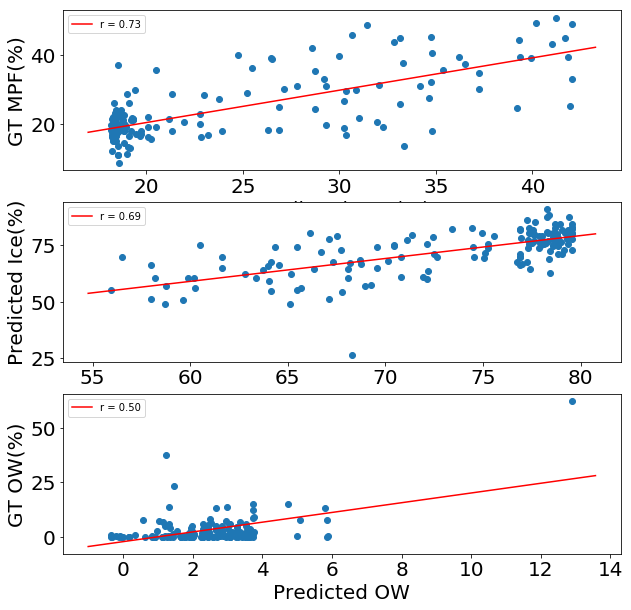

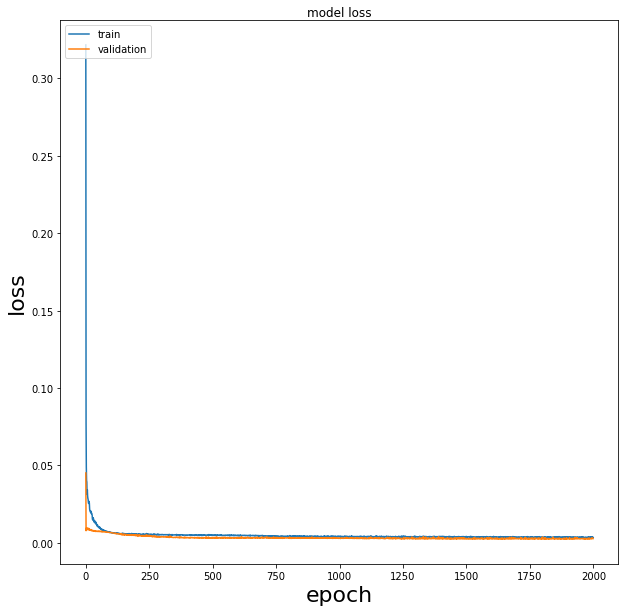

('iters:', 2000)
('batch size: ', 30)
Predicted Mean:  [ 24.2851963   73.15493774   2.40792465]
Ground Truth Mean:  [ 24.49310605  72.42300056   3.08389339]
Overall MPF MSE:  0.848826719146
0.85% (+/- 0.00%), average correlation: 0.73% (+/- 0.00%)


0

In [66]:
import os
import MySQLdb
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution1D, MaxPooling1D, TimeDistributedDense
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
plt.rcParams['axes.labelsize'] = 22
#mysql connection
con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")

def rmsep(v1,v2):
    return 100*len(v2)*sqrt(mean_squared_error(v2,v1))/v2.sum()

def pattern_test(train_x,train_y,test_x,test_y,iters,bsize,outputs,plot_on,model_id):  
    print('Use model: ', model_id)
    #train with model
    if model_id == 1:
        #build model basic MLP
        model = Sequential()
        model.add(Dense(100, input_dim=fea_num))
        model.add(Activation('tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(50))
        model.add(Activation('tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(50))
        model.add(Activation('tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(10))
        model.add(Activation('sigmoid'))
        model.add(Dropout(0.2))
        model.add(Dense(outputs))
        #sgd = SGD(lr=0.001, clipnorm=1.)
        model.compile(loss='mean_squared_error', optimizer='adam')
    
    if model_id == 2:
        #build model basic MLP
        model = Sequential()
        model.add(Dense(24, input_dim=fea_num))
        model.add(Activation('tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(12))
        model.add(Activation('tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(12))
        model.add(Activation('sigmoid'))
        model.add(Dropout(0.2))
        model.add(Dense(outputs))
        #sgd = SGD(lr=0.001, clipnorm=1.)
        model.compile(loss='mean_squared_error', optimizer='adam')
    
    if model_id == 3:
        #build model basic MLP
        model = Sequential()
        model.add(Dense(3, input_dim=fea_num))
        model.add(Activation('tanh'))
        model.add(Dense(6))
        model.add(Activation('sigmoid'))
        model.add(Dense(outputs))
        #sgd = SGD(lr=0.001, clipnorm=1.)
        model.compile(loss='mean_squared_error', optimizer='adam')
    #evaluate model
    history = model.fit(train_x, train_y,
              nb_epoch=iters,
              batch_size=bsize,
              verbose = 0,validation_split=0.10)
    #visualize results
    predicted_mpf = model.predict(test_x)*100
    test_ytr = test_y*100
    if plot_on:
        if outputs == 1:
            print "RMSE MPF: ", sqrt(mean_squared_error(predicted_mpf,test_ytr))
            print "RMSEP MPF: ", rmsep(test_ytr,predicted_mpf)
            t = np.arange(0, len(test_ytr), 1)
            plt.scatter(predicted_mpf, test_ytr)
            axes = plt.gca()
            predicted_mpf = predicted_mpf.T
            test_ytr = test_ytr.T
            r = np.corrcoef(predicted_mpf, test_ytr)[1,0]
            print ("Correlation: ", r)
            #print out model
            SVG(model_to_dot(model).create(prog='dot', format='svg'))
            print('iters:', iters)
            print('batch size: ', bsize)
        else:
            print "RMSE MPF: ", 100*len(test_ytr[:,0])*sqrt(mean_squared_error(predicted_mpf[:,0],test_ytr[:,0]))/test_ytr[:,0].sum()
            print "RMSE Ice/Snow: ", 100*len(test_ytr[:,1])*sqrt(mean_squared_error(predicted_mpf[:,1],test_ytr[:,1]))/test_ytr[:,1].sum()
            print "RMSE OW: ", 100*len(test_ytr[:,2])*sqrt(mean_squared_error(predicted_mpf[:,2],test_ytr[:,2]))/test_ytr[:,2].sum()

            t = np.arange(0, len(test_ytr), 1)
            plt.subplot(311)
            plt.scatter(predicted_mpf[:,0], test_ytr[:,0])
            axes = plt.gca()
            m, b = np.polyfit(predicted_mpf[:,0], test_ytr[:,0], 1)
            X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
            r = np.corrcoef(predicted_mpf[:,0], test_ytr[:,0])[1,0]
            plt.plot(X_plot, m*X_plot + b, 'r-',label="r = %2.2f"%(r))
            plt.legend(loc=2)
            plt.ylabel('GT MPF(%)',fontsize=20, color='black')
            plt.xlabel('Predicted MPF(%)',fontsize=20, color='black')
            plt.tick_params(axis='both', which='major', labelsize=20)

            plt.subplot(312)
            #plt.plot(t, predicted_mpf[:,1], 'r-', t, test_ytr[:,1], 'b-')
            plt.scatter(predicted_mpf[:,1], test_ytr[:,1])
            axes = plt.gca()
            m, b = np.polyfit(predicted_mpf[:,1], test_ytr[:,1], 1)
            X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
            r = np.corrcoef(predicted_mpf[:,1], test_ytr[:,1])[1,0]
            plt.plot(X_plot, m*X_plot + b, 'r-',label="r = %2.2f"%(r))
            plt.legend(loc=2)
            plt.ylabel('GT Ice(%)',fontsize=20, color='black')
            plt.ylabel('Predicted Ice(%)',fontsize=20, color='black')
            plt.tick_params(axis='both', which='major', labelsize=20)

            plt.subplot(313)
            plt.scatter(predicted_mpf[:,2], test_ytr[:,2])
            axes = plt.gca()
            m, b = np.polyfit(predicted_mpf[:,2], test_ytr[:,2], 1)
            X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
            r = np.corrcoef(predicted_mpf[:,2], test_ytr[:,2])[1,0]
            plt.plot(X_plot, m*X_plot + b, 'r-',label="r = %2.2f"%(r))
            plt.legend(loc=2)
            plt.ylabel('GT OW(%)',fontsize=20, color='black')
            plt.ylabel('GT OW(%)',fontsize=20, color='black')
            plt.tick_params(axis='both', which='major', labelsize=20)
            plt.xlabel('Predicted OW',fontsize=20, color='black')
            plt.show()

            # summarize history for loss
            plt.figure
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

            #print out model
            SVG(model_to_dot(model).create(prog='dot', format='svg'))
            print('iters:', iters)
            print('batch size: ', bsize)
    return predicted_mpf,test_ytr,model #test return
#testing patterns
#parameters
pattern = 3#sites cross validatetion - 0; temporal cross validation - 1, 2-single day self test - 2, overall model - 3
fea_num = 7
out_num = 3
model_id = 1#basic model
sites = ['Esiber','Cacana']#,'Beaufo']Cacana
iters = 2000
bsize = 30
quality_view = 0#print out QA data
plot_on = 1
seed = 7

def minmaxscaler(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)#,columns = ["b1","b2","b3","b4","b5","b6","b7","MP_F","I_F","W_F"]
    return df

if pattern == 0:
    #sites, train one sites and use another 3 as test
    for site in sites:
        print sites
        #train with site
        sql_train = '''SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F
                        FROM %s''' % (site)
        df_train = pd.read_sql(sql_train, con)
        df_train = df_train.replace(-9999, 0)
        sites_temp = sites[:]
        sites_temp.remove(site)#remove one, test the rest
        for site_test in sites_temp:
            #get test data
            sql_test = '''SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F
                            FROM %s''' % (site_test)
            df_test = pd.read_sql(sql_test, con)
            df_tests = df_test.replace(-9999, 0)
            #train and evaluate model
            pattern_test(df_train,df_test,iters,bsize,out_num)
            
elif pattern == 1:
    for site in sites:
        days_sql = """SELECT DISTINCT
                year,day,day_label
                FROM %s
                WHERE day_label != 'M'
                ORDER BY year,day
                """ % (site)
        #WHERE day_label != 'a'
        days = pd.read_sql(days_sql, con)
        num_days = len(days.index)
        days_list = np.linspace(0, num_days-1, num=num_days, dtype=int).tolist()
        #train day to day, how far can predict?
        for i in range(0,num_days):
            dayi = days.iloc[i,1]
            yeari = days.iloc[i,0]
            day_labeli = days.iloc[i,2]
            sql_train = """SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F
                        FROM %s
                        WHERE year = %d
                        AND
                        day = %d
                        AND
                        day_label = '%s'""" % (site,yeari,dayi,day_labeli)
            df_train = pd.read_sql(sql_train, con)
            df_train = df_train.replace(-9999, 0)
            days_temp = days_list[:]
            days_temp.remove(i)#remove one, test the rest
            for day_id in days_temp:
                dayt = days.iloc[day_id,1]
                yeart = days.iloc[day_id,0]
                day_labelt = days.iloc[day_id,2]
                
                sql_test = """SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F
                            FROM %s
                            WHERE year = %d
                            AND
                            day = %d
                            AND
                            day_label = '%s'""" % (site,yeart,dayt,day_labelt)
                df_test = pd.read_sql(sql_test, con)
                df_test = df_test.replace(-9999, 0)
                #train and evaluate model
                print('Testing with site: ', site)
                print('Train day: ', dayi, 'Test day: ', dayt)
                pattern_test(df_train,df_test,iters,bsize,out_num)

elif pattern == 2:#single image test mode, test each day from each site
    for site in sites:
        days_sql = """SELECT DISTINCT
                year,day,day_label
                FROM %s
                WHERE day_label != 'M'
                ORDER BY year,day
                """ % (site)
        days = pd.read_sql(days_sql, con)
        num_days = len(days.index)
        days_list = np.linspace(0, num_days-1, num=num_days, dtype=int).tolist()
        #test a day
        for i in range(0,num_days):
            dayi = days.iloc[i,1]
            yeari = days.iloc[i,0]
            day_labeli = days.iloc[i,2]
            #random partition
            sql_df = """SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F
                            FROM %s
                            WHERE year = %d
                            AND
                            day = %d
                            AND
                            day_label = '%s'""" % (site,yeari,dayi,day_labeli)
            df = pd.read_sql(sql_df, con)
            df = df.replace(-9999, 0)
            df = minmaxscaler(df)
            np.random.seed(1)
            msk = np.random.rand(len(df)) < 0.8
            df_train = df[msk]
            df_test = df[~msk]
            print('Testing with site: ', site)
            print('Test day: ', dayi, day_labeli)
            pattern_test(df_train,df_test,iters,bsize,out_num)
            
            if quality_view == 1:
                #print quality histogram, 00, 01, 10, 11
                sql_quality = """SELECT b8
                        FROM %s
                        WHERE year = %d
                        AND
                        day = %d
                        AND
                        day_label = '%s'""" % (site,yeari,dayi,day_labeli)
                qa = pd.read_sql(sql_quality, con)
                print pd.value_counts(qa['b8'].values)/len(qa)*100

if pattern == 3:
    #train with all data 80%, test on the rest
    sql = """
            SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_f,W_F FROM Beaufo
            WHERE MP_F <= 1 AND day != 238 AND day != 244 AND day != 246
            AND day_label = 'a'
            UNION
            SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_f,W_F FROM Esiber
            WHERE MP_F <= 1 AND day != 195
            AND day_label = 'a'
            UNION
            SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_f,W_F FROM Cacana
            WHERE MP_F <= 1 AND day != 181 AND day != 192
            AND day_label = 'a'
            UNION
            SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_f,W_F FROM Cafram
            WHERE MP_F <= 1 AND day != 179
            AND day_label = 'a'
            """
    df = pd.read_sql(sql, con)
    df = df.replace(-9999, 0)
    #df = minmaxscaler(df)
    data = df.as_matrix()
    X = data[:,0:fea_num]
    Y = data[:,fea_num:fea_num+out_num]
    
    cvscores = []
    cvr = []
    
    kfold = 1
    if kfold == 0:#validate for model architecture
        # define 10-fold cross validation test harness
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        #get ready train_x,train_y,test_x,test_y
        for train, test in kfold.split(X):
            print 'Model Shallow-'
            predicted, gtest, model = pattern_test(X[train],Y[train],X[test],Y[test],iters,bsize,out_num,plot_on,model_id)
            score = model.evaluate(X[test], Y[test], batch_size=bsize, verbose=0)
            print 'Predicted Mean: ', np.mean(predicted,axis=0)
            print 'Ground Truth Mean: ', np.mean(gtest,axis=0)
            mpf_mse = np.absolute(np.mean(predicted[:,0],axis=0)-np.mean(gtest[:,0],axis=0))/np.mean(gtest[:,0],axis=0)*100
            print 'Overall MPF MSE: ', mpf_mse
            r = np.corrcoef(predicted[:,0], gtest[:,0])[1,0]
            cvr.append(r)
            cvscores.append(mpf_mse)
   
    else:#no split, to get best weigths for all data
        np.random.seed(1)
        msk = np.random.rand(len(df)) < 0.8
        print('size of data: ', len(df))
        X_train = X[msk]
        X_test = X[~msk]
        Y_train = Y[msk]
        Y_test = Y[~msk]
        predicted, gtest, model = pattern_test(X_train,Y_train,X_test,Y_test,iters,bsize,out_num,plot_on,model_id)
        score = model.evaluate(X_test, Y_test, batch_size=bsize, verbose=0)
        print 'Predicted Mean: ', np.mean(predicted,axis=0)
        print 'Ground Truth Mean: ', np.mean(gtest,axis=0)
        mpf_mse = np.absolute(np.mean(predicted[:,0],axis=0)-np.mean(gtest[:,0],axis=0))/np.mean(gtest[:,0],axis=0)*100
        print 'Overall MPF MSE: ', mpf_mse
        r = np.corrcoef(predicted[:,0], gtest[:,0])[1,0]
        cvr.append(r)
        cvscores.append(mpf_mse)
        #save current model
        model.save('recent_model_m3.h5')

print("%.2f%% (+/- %.2f%%), average correlation: %2.2f%% (+/- %2.2f%%)" % (np.mean(cvscores), np.std(cvscores), np.mean(cvr), np.std(cvr)))
        
#generate results report
os.system('espeak "Congratulations, Your test is done"')


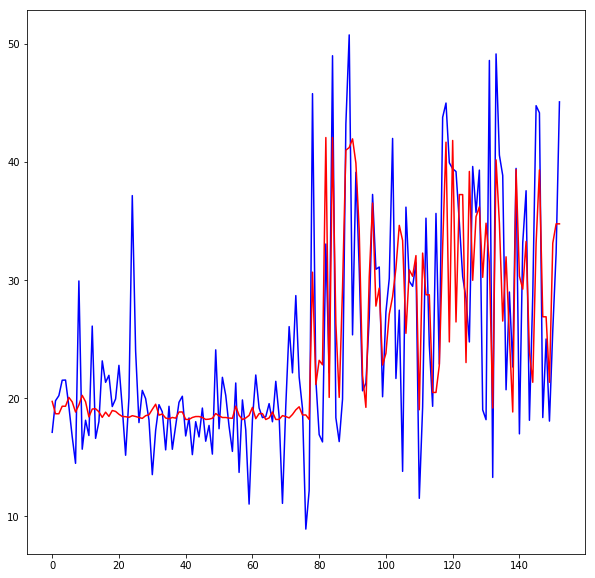

In [67]:
t = np.arange(0, len(gtest), 1)
plt.plot(t, gtest[:,0], 'b-',t, predicted[:,0], 'r-')

In [57]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")
sql = """SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F 
FROM Beaufo WHERE day = 238 AND day_label = 'N'"""
df = pd.read_sql(sql, con)
df = df.replace(-9999, 0)
df = minmaxscaler(df)#
axes = scatter_matrix(df, alpha=0.7, figsize=(14, 14), diagonal='kde')
corr = df.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), 
                        xycoords='axes fraction', ha='center', va='center',color='red',fontsize='16')
plt.show()

In [ ]:
con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")
sql = """SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F FROM Beaufo
UNION
SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F FROM Cacana
UNION
SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F FROM Esiber
UNION
SELECT b1,b2,b3,b4,b5,b6,b7,MP_F,I_F,W_F FROM Cafram"""
df = pd.read_sql(sql, con)
newdf = df.replace(-9999, 0)
axes = scatter_matrix(newdf, alpha=0.7, figsize=(14, 14), diagonal='kde')
corr = df.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

186.0
195.0
210.0
240.0


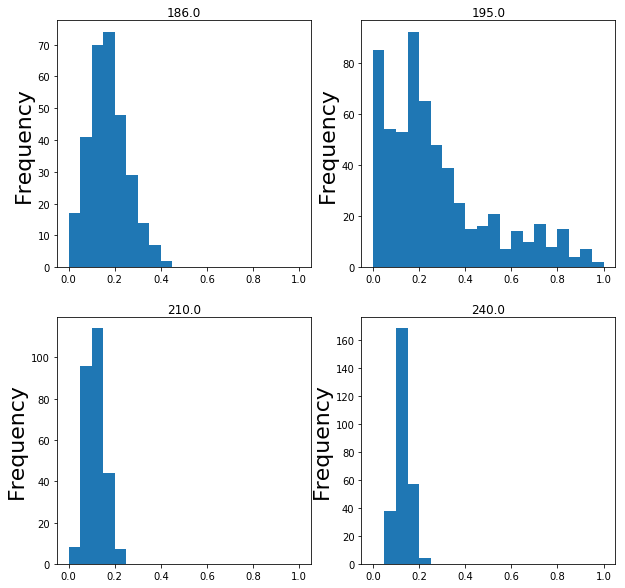

In [141]:
import math

con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")
sql = """SELECT MP_F,day FROM Esiber"""
df = pd.read_sql(sql, con)
df = df.replace(-9999, 0)
df = df.groupby(['day'])
for name, group in df:
    print(name)
#Setup Subplots
nrows = int(math.ceil(len(df)/2.))
fig, axs = plt.subplots(nrows,2)
for (i,j), ax in zip(df, axs.flat):
    fig = j['MP_F'].plot.hist(bins=20, ax=ax, range=[0,1.0], title=i)

In [ ]:
mpf = 100 - (predicted[:,2] + predicted[:,1])
plt.scatter(mpf, gtest[:,0])
axes = plt.gca()
m, b = np.polyfit(mpf, gtest[:,0], 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
r = np.corrcoef(mpf, gtest[:,0])[1,0]
plt.plot(X_plot, m*X_plot + b, 'r-',label="r = %2.2f"%(r))
plt.legend(loc=2)
plt.ylabel('True (%)',fontsize=20, color='black')
plt.ylabel('Predicted (%)',fontsize=20, color='black')
plt.tick_params(axis='both', which='major', labelsize=20)

In [ ]:
#TO DO Code:
#1. easy configuration of features selection
#2. seperate into models with config file...integrate to the py script framework
#code to-do notes:
#1. output ordering bug?
#2. too long, make into modules
#if increase layers, better to increase the number of nodes at eacy layer largely?